In [1]:
test_mp4, test_depth, test_intr = "./raw_data/rgb_20250712_004014", "./raw_data/depth_20250712_004014", "./raw_data/intrinsics_20250712_004014"

In [2]:
import cv2
from frame_processor import FrameProcessor
from mock_camera import MockCamera

from config import Config 

camera_intrinsics = Config.CAMERA_INTRINSICS
#Config.CAMERA_INTRINSICS

camera = MockCamera(rgb_folder=test_mp4, depth_folder=test_depth, intrinsics_folder=test_intr)
processor = FrameProcessor(camera_intrinsics)
processor.set_tracking_enabled(True)
camera.start()

# Обработка и отображение
while True:
   color, depth, depth_intrinsics= camera.get_frames()
   if color is None or depth is None:
       break
   
   # Обработка кадра
   results = processor.process_frame(color, depth, depth_intrinsics)
   
   # Отображение результата (combined = RGB + Depth + Cleaned)
   cv2.imshow('Processed Video', results['combined'])
   
   # Или только обработанный RGB с масками
   # cv2.imshow('Processed Video', results['color_with_mask'])
   
   if cv2.waitKey(25) & 0xFF == ord('q'):
       break

camera.stop()
cv2.destroyAllWindows()

# Вывод статистики
print(f"Обработано кадров: {processor.frame_count}")

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
TOP DIMENSIONS:
0: [    0.36724     0.36053     0.16938]
1: [     1.1752     0.45569    0.013137]
2: [    0.60302     0.32151     0.28745]
3: [     1.0394     0.71045    0.011333]
4: [    0.97689     0.42675     0.11552]
5: [    0.95281     0.41594       0.272]
Object 0: габариты 0.367x0.361x0.169 м, объем 0.0224 м³, 377 точек
[FILTER] IoU too low: 0.09
TOP DIMENSIONS:
0: [    0.52441     0.39242     0.19062]
1: [    0.49829      0.3228     0.20344]
2: [     0.5056     0.33612     0.22133]
3: [    0.48707     0.32543     0.17878]
4: [    0.74297      0.5408     0.20193]
5: [    0.51471     0.35058     0.23202]
Object 1: габариты 0.524x0.392x0.191 м, объем 0.0392 м³, 804 точек
TOP DIMENSIONS:
0: [    0.41232     0.25139     0.13071]
1: [    0.26964     0.18972     0.08071]
2: [    0.44654     0.36917     0.12358]
3: [   

In [3]:
import numpy as np
completed_objects = processor.get_completed_objects()
print(f"\nЗавершено объектов: {len(completed_objects)}")

# Анализ результатов
for idx, obj in enumerate(completed_objects):
    print(f"\n Объект №: {idx}")
    print(f"  Точек в облаке: {len(obj['point_cloud'])}")
    print(f"  Всего масок: {len(obj['all_masks'])}")
    print(f"  Габариты: {obj['dimensions'][0]:.3f}x{obj['dimensions'][1]:.3f}x{obj['dimensions'][2]:.3f} м, ")


Завершено объектов: 4

 Объект №: 0
  Точек в облаке: 377
  Всего масок: 9
  Габариты: 0.367x0.361x0.169 м, 

 Объект №: 1
  Точек в облаке: 804
  Всего масок: 19
  Габариты: 0.524x0.392x0.191 м, 

 Объект №: 2
  Точек в облаке: 299
  Всего масок: 11
  Габариты: 0.412x0.251x0.131 м, 

 Объект №: 3
  Точек в облаке: 324
  Всего масок: 34
  Габариты: 0.434x0.304x0.119 м, 


In [4]:
import open3d as o3d
import numpy as np

def visualize_point_cloud_with_bbox(result):
    """Визуализация облака точек с ориентированным bounding box"""
    # Создаем облако точек
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(result['point_cloud'])
    pcd.paint_uniform_color([0.5, 0.5, 0.5])
    
    # Создаем линии для отображения bounding box
    bbox_lines = create_bbox_lines(result['centroid'], result['dimensions'], result['rotation_matrix'])
    
    # Текст с размерами
    print(f"Габариты: {result['dimensions'][0]:.3f} x {result['dimensions'][1]:.3f} x {result['dimensions'][2]:.3f} м")
    print(f"Объем: {result['volume']:.4f} м³")
    print(f"Точек: {result['num_points']}")
    
    # Визуализация
    o3d.visualization.draw_geometries(
        [pcd, bbox_lines],
        window_name="Облако точек с габаритами",
        width=800, height=600
    )

def create_bbox_lines(center, extent, rotation):
    """Создание линий bounding box"""
    # Вершины box в локальных координатах
    corners = np.array([
        [-extent[0]/2, -extent[1]/2, -extent[2]/2],
        [extent[0]/2, -extent[1]/2, -extent[2]/2],
        [extent[0]/2, extent[1]/2, -extent[2]/2],
        [-extent[0]/2, extent[1]/2, -extent[2]/2],
        [-extent[0]/2, -extent[1]/2, extent[2]/2],
        [extent[0]/2, -extent[1]/2, extent[2]/2],
        [extent[0]/2, extent[1]/2, extent[2]/2],
        [-extent[0]/2, extent[1]/2, extent[2]/2]
    ])
    
    # Поворот и смещение
    corners = (rotation @ corners.T).T + center
    
    # Индексы линий
    lines = [[0,1],[1,2],[2,3],[3,0],
             [4,5],[5,6],[6,7],[7,4],
             [0,4],[1,5],[2,6],[3,7]]
    
    # Создание LineSet
    line_set = o3d.geometry.LineSet()
    line_set.points = o3d.utility.Vector3dVector(corners)
    line_set.lines = o3d.utility.Vector2iVector(lines)
    line_set.colors = o3d.utility.Vector3dVector([[1, 0, 0] for _ in lines])
    
    return line_set

In [5]:
IDX = 1
visualize_point_cloud_with_bbox(completed_objects[IDX])

Габариты: 0.524 x 0.392 x 0.191 м
Объем: 0.0392 м³
Точек: 804


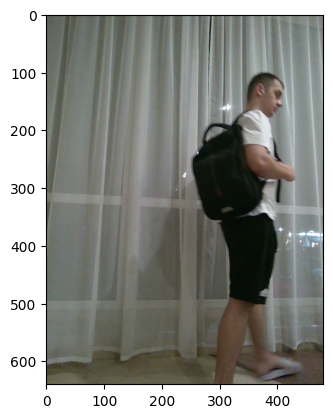

In [6]:
import matplotlib.pyplot as plt
plt.imshow(cv2.cvtColor(completed_objects[IDX]['rgb_image'], cv2.COLOR_BGR2RGB))

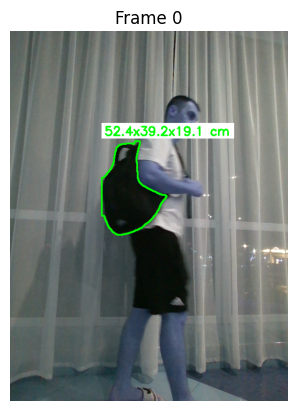

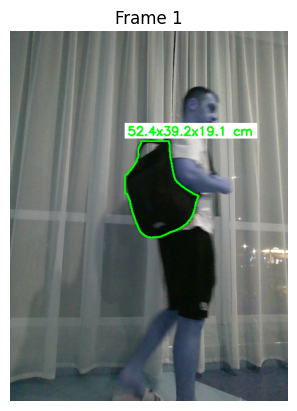

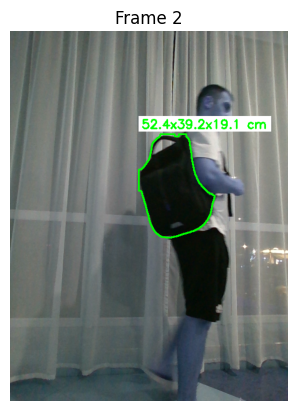

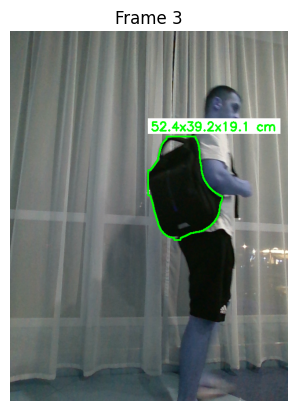

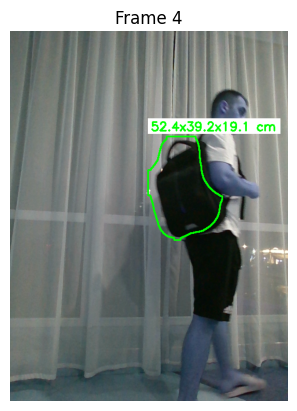

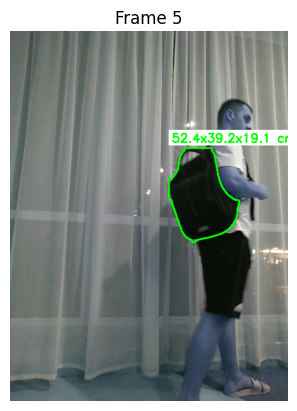

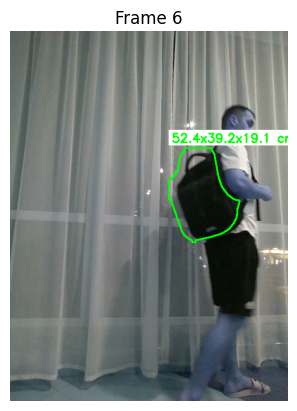

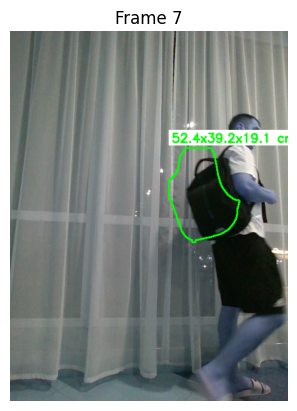

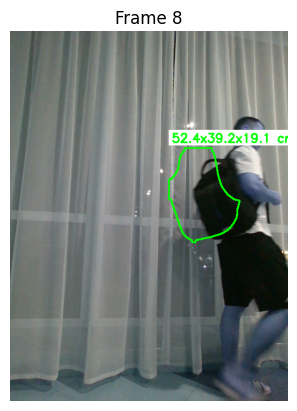

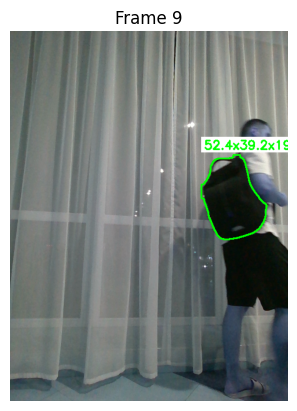

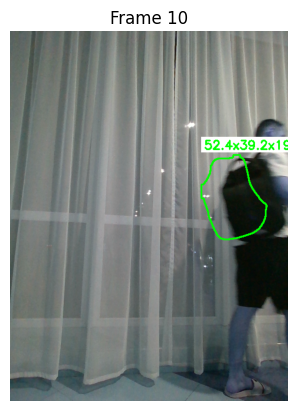

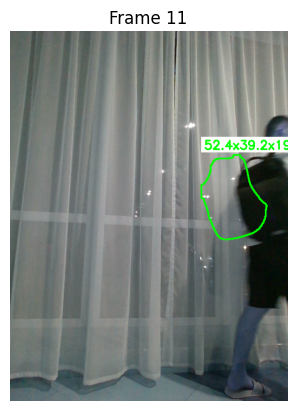

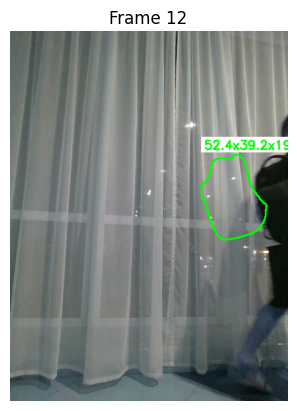

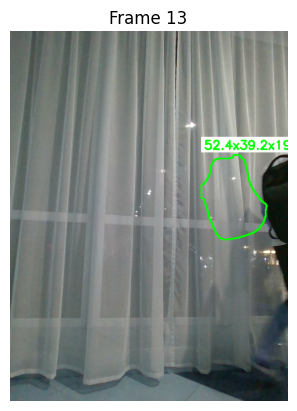

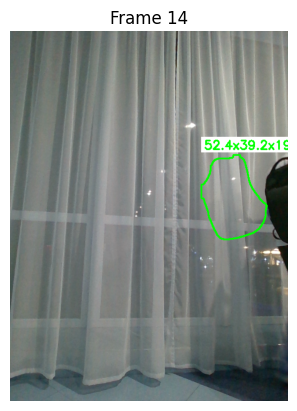

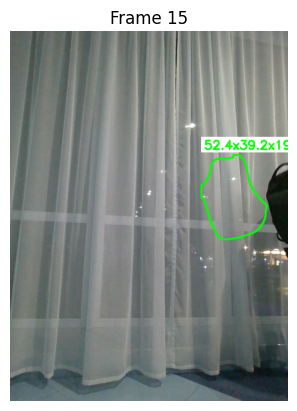

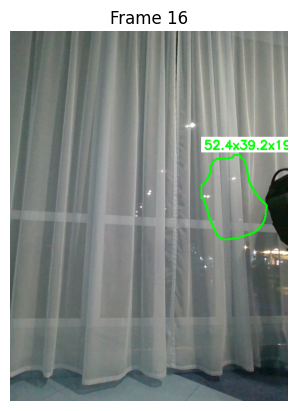

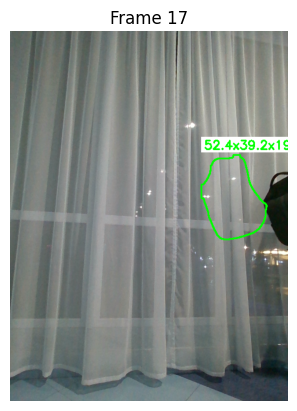

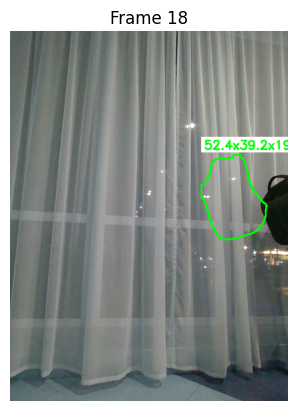

<Figure size 640x480 with 0 Axes>

In [9]:
#all_masks = completed_objects[IDX]['all_masks']
import time
import matplotlib.pyplot as plt

obj = completed_objects[IDX]

for i in range(len(obj['all_masks'])):
    obj['best_frame_index'] = i
    vis = processor.create_object_visualization(obj, [1, 1, 1])

    plt.imshow(vis)
    plt.axis('off')
    plt.title(f'Frame {i}')
    plt.pause(0.5)  # Задержка между кадрами
    plt.clf()       # Очистка перед следующим изображением


In [8]:
for i in range(10):
    print(obj['all_masks'][i]['mask'].mean())

8.851123046875
11.352978515625
13.376708984375
13.126025390625
13.126025390625
11.14794921875
11.14794921875
11.14794921875
11.14794921875
9.460400390625
